In [1]:
%cd /home/Reguformer/notebooks

/home/Reguformer/notebooks


In [2]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from copy import deepcopy
from tqdm import tqdm

from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from scipy.spatial.distance import cosine

import warnings
warnings.filterwarnings('ignore')

from trans_oil_gas import utils_dataset, utils_attn, utils_fix_seeds, utils_model

Set parameters for plots.

In [3]:
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=16)   # fontsize of the figure title

Choose GPU device if it is available.

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
gpu = [0] if 'cuda' in device.type else 0
device, gpu

(device(type='cpu'), 0)

Fix all possible seeds for results reproducibility.

In [5]:
utils_fix_seeds.fix_seeds(device=device)

# Read data

Reading of already preprocessed data (here synthetic dataset with the same columns as in the original one is presented).

In [6]:
df = pd.read_csv('../data/synthetic_well_log_data.csv')
df

,DRHO,DENS,GR,DTC,WELLNAME
0,0.01778,2.3794,1.214982,101.5516,26
1,0.01701,2.3705,1.086457,101.6722,26
2,0.01624,2.3615,0.957933,101.7928,26
3,0.01779,2.3593,0.493992,101.1051,26
4,0.02008,2.3591,-0.076734,100.1601,26
...,...,...,...,...,...
730,0.11269,2.6161,0.742381,92.0410,127
731,0.11269,2.6161,0.775581,92.1752,127
732,0.11269,2.6161,0.686798,91.6055,127
733,0.11269,2.6161,0.614402,91.7522,127


In [7]:
slice_len = 100
well_column = "WELLNAME"
path_to_save = './saves_attn_analysis_tr'

if not os.path.exists(path_to_save):
    os.mkdir(path_to_save)

# Generate dataset and create dataloader

In [8]:
_, val_slice_dataset = utils_dataset.generate_datasets(
    df, df,
    well_column='WELLNAME',
    slice_len=slice_len,
    path_to_saves=path_to_save,
    results_len_train=0,
    # results_len_test=5000,
    results_len_test=50,
)    

In [9]:
batch_size = 64

In [10]:
val_dataloader = DataLoader(
    val_slice_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)

# Models' params

In [11]:
fixed_params_tr = {
    "enc_in": 4,
    "distil": None,
    "device": device,
    "attn": "full",
    "activation": "relu",
    "output_attention": True,
    "n_seq": 100
}

In [12]:
path_to_models = "./saves_all_models/"

# Elimination of parts of well-intervals with 0s or white noise

In [13]:
# P = [i * 10 for i in range(1, 10)]
P = [i * 10 for i in range(1, 3)]

In [14]:
def get_proba(model, model_type, slice_1, slice_2, distance_type):
    if "siamese" in model_type and distance_type == "None":
        return model((slice_1, slice_2)).detach().cpu().numpy()[:, 0]
    
    pred_1 = model.encode(slice_1).detach().cpu().numpy()
    pred_2 = model.encode(slice_2).detach().cpu().numpy()
    
    if distance_type == "euclidean":
        dist_12 = np.linalg.norm(pred_1 - pred_2, ord=2, axis=1)
        return 1 / (1 + dist_12)
    elif distance_type == "cosine":
        dist_12 = np.array(
            [cosine(pred_1[i], pred_2[i]) for i in range(len(pred_1))]
        )
        return 1 - dist_12

In [15]:
ans = {
    "model_type": [], 
    "loss_type": [], 
    "reg_type": [], 
    "p": [], 
    "elimination_type": [], 
    "acc": [], 
    "roc_auc": [], 
    "pr_auc": [],
    "distance_type": [],
}
all_distances = ["None", "euclidean", "cosine"]

for loss_type in ["siamese", "triplet"]:
    with open(os.path.join(path_to_models, "best_params_{}_reguformer_None.json".format(loss_type)), "r") as f:
        best_params = json.load(f)

    if "siamese" in loss_type:
        model = utils_model.SiameseArchitecture(
            encoder_type="reguformer", 
            fc_hidden_size=64, 
            **fixed_params_tr,
            **best_params,
        ).float()
        distances = deepcopy(all_distances)

    elif "triplet" in loss_type:
        model = utils_model.TripletArchitecture(
            encoder_type="reguformer",
            **fixed_params_tr,
            **best_params,
        ).float()
        distances = all_distances[1:]

    print('loading model...')
    model.load_state_dict(torch.load(os.path.join(path_to_models, "res_{}_transformer.pth".format(loss_type)), map_location=device))
    print('model loaded')
    model.eval()

    for p in P:
        for slice_1, positive, negative, well in tqdm(val_dataloader):
            slice_1 = slice_1.to(device)
            slice_1_g_0, slice_1_a_0 = utils_attn.change_interval_part_grads_attns(
                slice_1, 
                model, 
                "transformer-"+loss_type,
                fill_with="zeros",
                p=p / 100,
                grads_abs=True,
                attns_abs=True, 
                elim_mode_grads="largest",
                elim_mode_attns="smallest",
            )
            slice_1_g_r, slice_1_a_r = utils_attn.change_interval_part_grads_attns(
                slice_1, 
                model, 
                "transformer-"+loss_type,
                fill_with="rand",
                p=p / 100,
                grads_abs=True,
                attns_abs=True, 
                elim_mode_grads="largest",
                elim_mode_attns="smallest",
            ) 
            targets = np.array([])
            probas = {
                "None": {"grad_0": np.array([]), "grad_rand": np.array([]), "attn_0": np.array([]), "attn_rand": np.array([])},
                "euclidean": {"grad_0": np.array([]), "grad_rand": np.array([]), "attn_0": np.array([]), "attn_rand": np.array([])},
                "cosine": {"grad_0": np.array([]), "grad_rand": np.array([]), "attn_0": np.array([]), "attn_rand": np.array([])},
            }
            for slice_2, target in zip(
                [positive, negative],
                [np.ones(slice_1.shape[0]), np.zeros(slice_1.shape[0])]
            ):
                slice_2 = slice_2.to(device)
                slice_2_g_0, slice_2_a_0 = utils_attn.change_interval_part_grads_attns(
                    slice_2, 
                    model, 
                    "transformer-"+loss_type,
                    fill_with="zeros",
                    p=p / 100,
                    grads_abs=True,
                    attns_abs=True, 
                    elim_mode_grads="largest",
                    elim_mode_attns="smallest",
                )
                slice_2_g_r, slice_2_a_r = utils_attn.change_interval_part_grads_attns(
                    slice_2, 
                    model, 
                    "transformer-"+loss_type,
                    fill_with="rand",
                    p=p / 100,
                    grads_abs=True,
                    attns_abs=True, 
                    elim_mode_grads="largest",
                    elim_mode_attns="smallest",
                ) 
                targets = np.concatenate([targets, target])
                
                for dist_type in distances:
                    for intervals_type, slices in zip(
                        ["grad_0", "grad_rand", "attn_0", "attn_rand"],
                        [
                            {"slice_1": slice_1_g_0, "slice_2": slice_2_g_0}, 
                            {"slice_1": slice_1_g_r, "slice_2": slice_2_g_r}, 
                            {"slice_1": slice_1_a_0, "slice_2": slice_2_a_0},
                            {"slice_1": slice_1_a_r, "slice_2": slice_2_a_r},
                        ],
                    ):
                        probas[dist_type][intervals_type] = np.concatenate(
                            [
                                probas[dist_type][intervals_type], 
                                get_proba(model=model, model_type="transformer-"+loss_type, distance_type=dist_type, **slices),
                            ]
                        )

            for dist_type in distances:
                for elimination_type in ["grad_0", "grad_rand", "attn_0", "attn_rand"]:
                    ans["distance_type"].append(dist_type)
                    ans["elimination_type"].append(elimination_type)
                    ans["model_type"].append("transformer-"+loss_type)
                    ans["loss_type"].append(loss_type)
                    ans["reg_type"].append("transformer")
                    ans["p"].append(p)
                    for metric_name, metric in zip(
                        ["acc", "roc_auc", "pr_auc"],
                        [accuracy_score, roc_auc_score, average_precision_score],
                    ):
                        proba = probas[dist_type][elimination_type]

                        if metric_name == "acc":
                            proba = (proba > 0.5).astype(int)
                            
                        ans[metric_name].append(metric(targets, proba))

  0%|                                                                                    | 0/1 [00:00<?, ?it/s]

loading model...
model loaded


  0%|                                                                                    | 0/1 [00:00<?, ?it/s]

loading model...
model loaded


100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.80s/it]


In [16]:
ans_df = pd.DataFrame(ans)
ans_df.to_csv(os.path.join(path_to_save, 'attn_analysis_tr.csv'), index=False)
ans_df

,model_type,loss_type,reg_type,p,elimination_type,acc,roc_auc,pr_auc,distance_type
0,transformer-siamese,siamese,transformer,10,grad_0,0.54,0.5748,0.571437,None
1,transformer-siamese,siamese,transformer,10,grad_rand,0.56,0.5724,0.629847,None
2,transformer-siamese,siamese,transformer,10,attn_0,0.62,0.6116,0.593346,None
3,transformer-siamese,siamese,transformer,10,attn_rand,0.63,0.6268,0.624952,None
4,transformer-siamese,siamese,transformer,10,grad_0,0.75,0.8584,0.858045,euclidean
5,transformer-siamese,siamese,transformer,10,grad_rand,0.72,0.8424,0.823557,euclidean
6,transformer-siamese,siamese,transformer,10,attn_0,0.81,0.9100,0.914502,euclidean
7,transformer-siamese,siamese,transformer,10,attn_rand,0.63,0.6956,0.726461,euclidean
8,transformer-siamese,siamese,transformer,10,grad_0,0.50,0.8620,0.868259,cosine
9,transformer-siamese,siamese,transformer,10,grad_rand,0.50,0.8348,0.815063,cosine


## Results analysis

In [17]:
ans_df = pd.read_csv(os.path.join(path_to_save, 'attn_analysis_tr.csv')) 
ans_df

,model_type,loss_type,reg_type,p,elimination_type,acc,roc_auc,pr_auc,distance_type
0,transformer-siamese,siamese,transformer,10,grad_0,0.54,0.5748,0.571437,None
1,transformer-siamese,siamese,transformer,10,grad_rand,0.56,0.5724,0.629847,None
2,transformer-siamese,siamese,transformer,10,attn_0,0.62,0.6116,0.593346,None
3,transformer-siamese,siamese,transformer,10,attn_rand,0.63,0.6268,0.624952,None
4,transformer-siamese,siamese,transformer,10,grad_0,0.75,0.8584,0.858045,euclidean
5,transformer-siamese,siamese,transformer,10,grad_rand,0.72,0.8424,0.823557,euclidean
6,transformer-siamese,siamese,transformer,10,attn_0,0.81,0.9100,0.914502,euclidean
7,transformer-siamese,siamese,transformer,10,attn_rand,0.63,0.6956,0.726461,euclidean
8,transformer-siamese,siamese,transformer,10,grad_0,0.50,0.8620,0.868259,cosine
9,transformer-siamese,siamese,transformer,10,grad_rand,0.50,0.8348,0.815063,cosine


In [18]:
rand_df = pd.read_csv(os.path.join('./saves_robustness', 'robustness_all_models_metrics.csv')) # results with random parts elimination
rand_df

,model_type,loss_type,reg_type,p,elimination_type,acc,roc_auc,pr_auc,distance_type
0,None-siamese,siamese,NaN,10,init,0.66,0.6828,0.710654,None
1,None-siamese,siamese,NaN,10,rand_0,0.59,0.6124,0.619756,None
2,None-siamese,siamese,NaN,10,rand_rand,0.59,0.6212,0.649824,None
3,None-siamese,siamese,NaN,10,init,0.91,0.9572,0.963811,euclidean
4,None-siamese,siamese,NaN,10,rand_0,0.84,0.9200,0.893944,euclidean
...,...,...,...,...,...,...,...,...,...
145,randQ_randK-triplet,triplet,randQ_randK,20,rand_0,0.53,0.9296,0.934743,euclidean
146,randQ_randK-triplet,triplet,randQ_randK,20,rand_rand,0.50,0.9228,0.909868,euclidean
147,randQ_randK-triplet,triplet,randQ_randK,20,init,0.82,0.9440,0.949606,cosine
148,randQ_randK-triplet,triplet,randQ_randK,20,rand_0,0.69,0.9320,0.937457,cosine


In [19]:
res_df = rand_df.append(ans_df) # add random elimination as baselines
res_df

,model_type,loss_type,reg_type,p,elimination_type,acc,roc_auc,pr_auc,distance_type
0,None-siamese,siamese,NaN,10,init,0.66,0.6828,0.710654,None
1,None-siamese,siamese,NaN,10,rand_0,0.59,0.6124,0.619756,None
2,None-siamese,siamese,NaN,10,rand_rand,0.59,0.6212,0.649824,None
3,None-siamese,siamese,NaN,10,init,0.91,0.9572,0.963811,euclidean
4,None-siamese,siamese,NaN,10,rand_0,0.84,0.9200,0.893944,euclidean
...,...,...,...,...,...,...,...,...,...
35,transformer-triplet,triplet,transformer,20,attn_rand,0.52,0.8280,0.829371,euclidean
36,transformer-triplet,triplet,transformer,20,grad_0,0.50,0.8960,0.900462,cosine
37,transformer-triplet,triplet,transformer,20,grad_rand,0.50,0.8368,0.778311,cosine
38,transformer-triplet,triplet,transformer,20,attn_0,0.50,0.9252,0.931067,cosine


In [20]:
res_df["reg_type"].fillna("transformer", inplace=True)

In [21]:
res_df["reg_type"].unique()

array(['transformer', 'topQ', 'topK', 'topQ_topK', 'randQ_randK'],
      dtype=object)

In [22]:
tr_siam_df = res_df[(res_df["reg_type"] == "transformer") & (res_df["loss_type"] == "siamese")]
tr_siam_df

,model_type,loss_type,reg_type,p,elimination_type,acc,roc_auc,pr_auc,distance_type
0,None-siamese,siamese,transformer,10,init,0.66,0.6828,0.710654,None
1,None-siamese,siamese,transformer,10,rand_0,0.59,0.6124,0.619756,None
2,None-siamese,siamese,transformer,10,rand_rand,0.59,0.6212,0.649824,None
3,None-siamese,siamese,transformer,10,init,0.91,0.9572,0.963811,euclidean
4,None-siamese,siamese,transformer,10,rand_0,0.84,0.9200,0.893944,euclidean
5,None-siamese,siamese,transformer,10,rand_rand,0.77,0.8908,0.854320,euclidean
6,None-siamese,siamese,transformer,10,init,0.50,0.9492,0.956954,cosine
7,None-siamese,siamese,transformer,10,rand_0,0.50,0.8972,0.867585,cosine
8,None-siamese,siamese,transformer,10,rand_rand,0.50,0.8880,0.855522,cosine
9,None-siamese,siamese,transformer,20,init,0.66,0.6828,0.710654,None


In [23]:
tr_siam_df["elimination_type"].unique()

array(['init', 'rand_0', 'rand_rand', 'grad_0', 'grad_rand', 'attn_0',
       'attn_rand'], dtype=object)

1it [00:00, 24.98it/s]
1it [00:00, 27.76it/s]
1it [00:00, 27.47it/s]
1it [00:00,  7.98it/s]
1it [00:00, 27.74it/s]
1it [00:00, 26.92it/s]
1it [00:00, 26.83it/s]
1it [00:00, 26.45it/s]
1it [00:00, 27.06it/s]


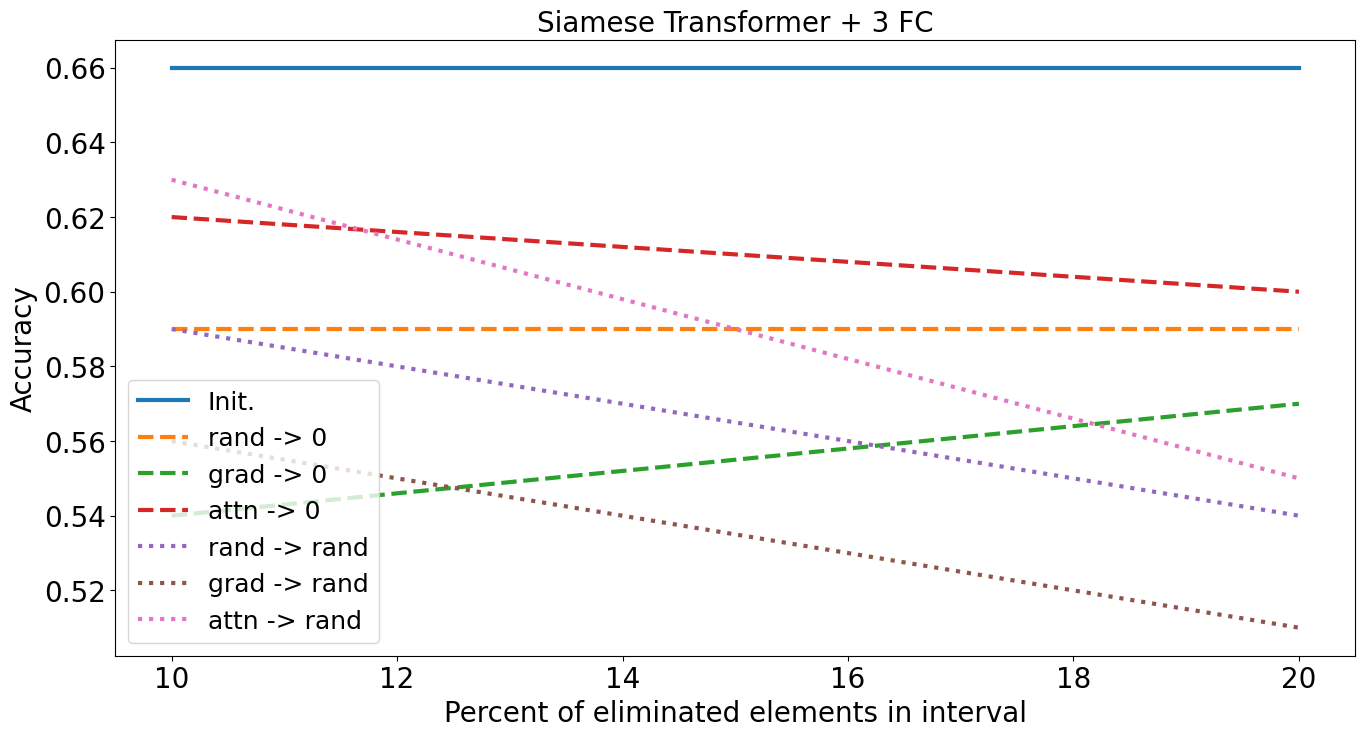

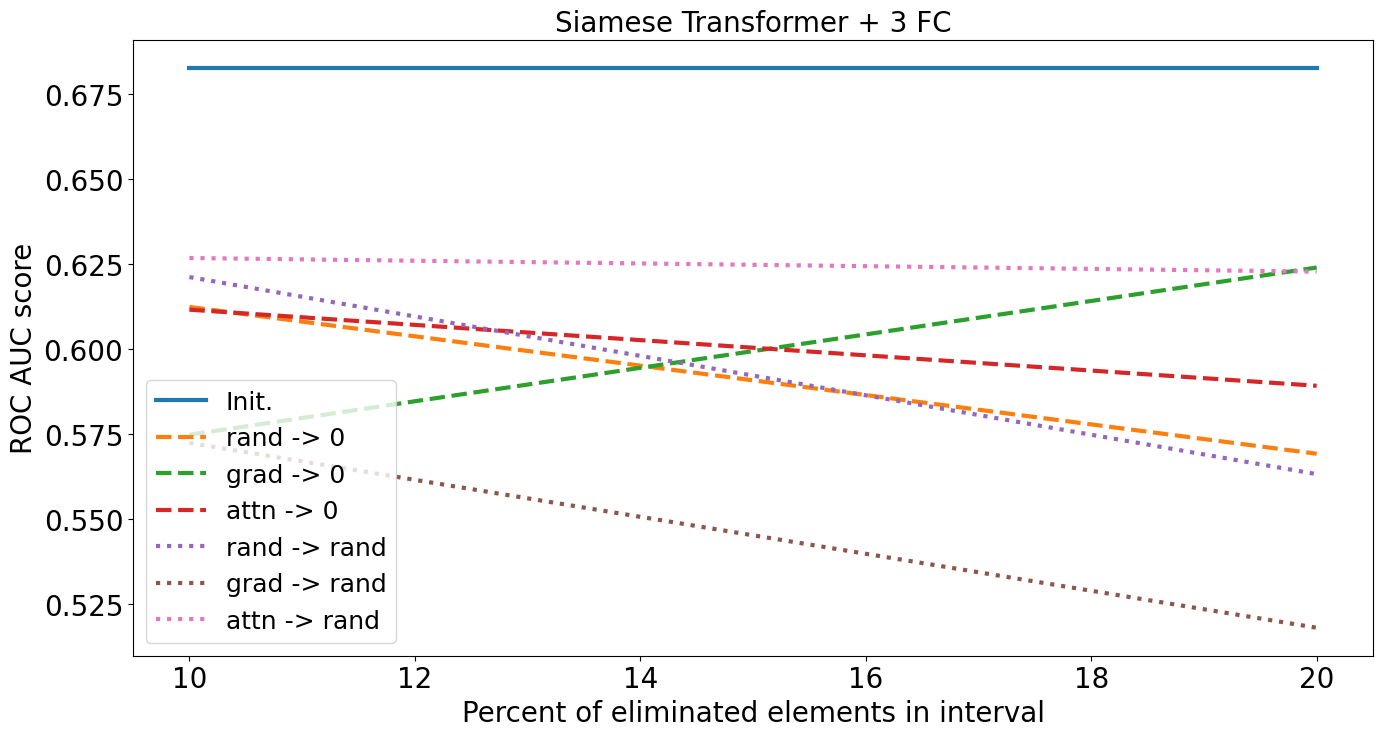

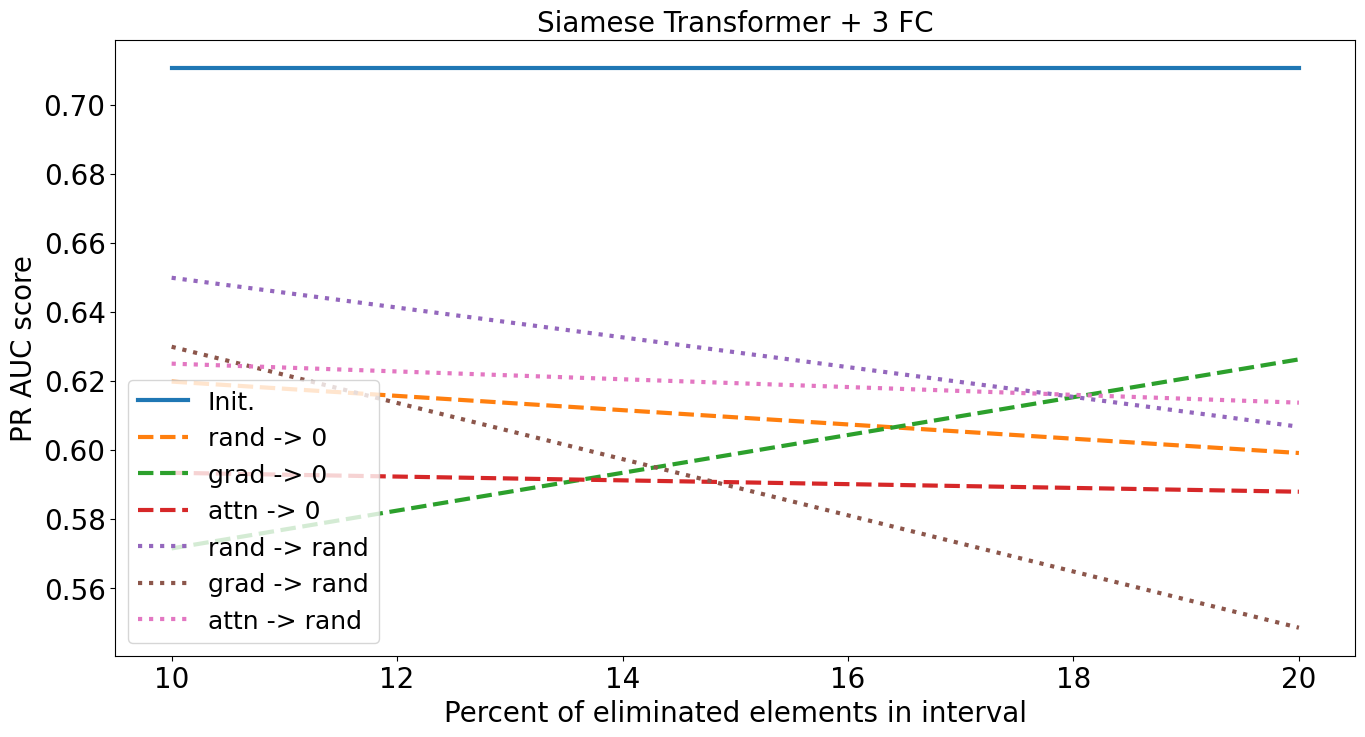

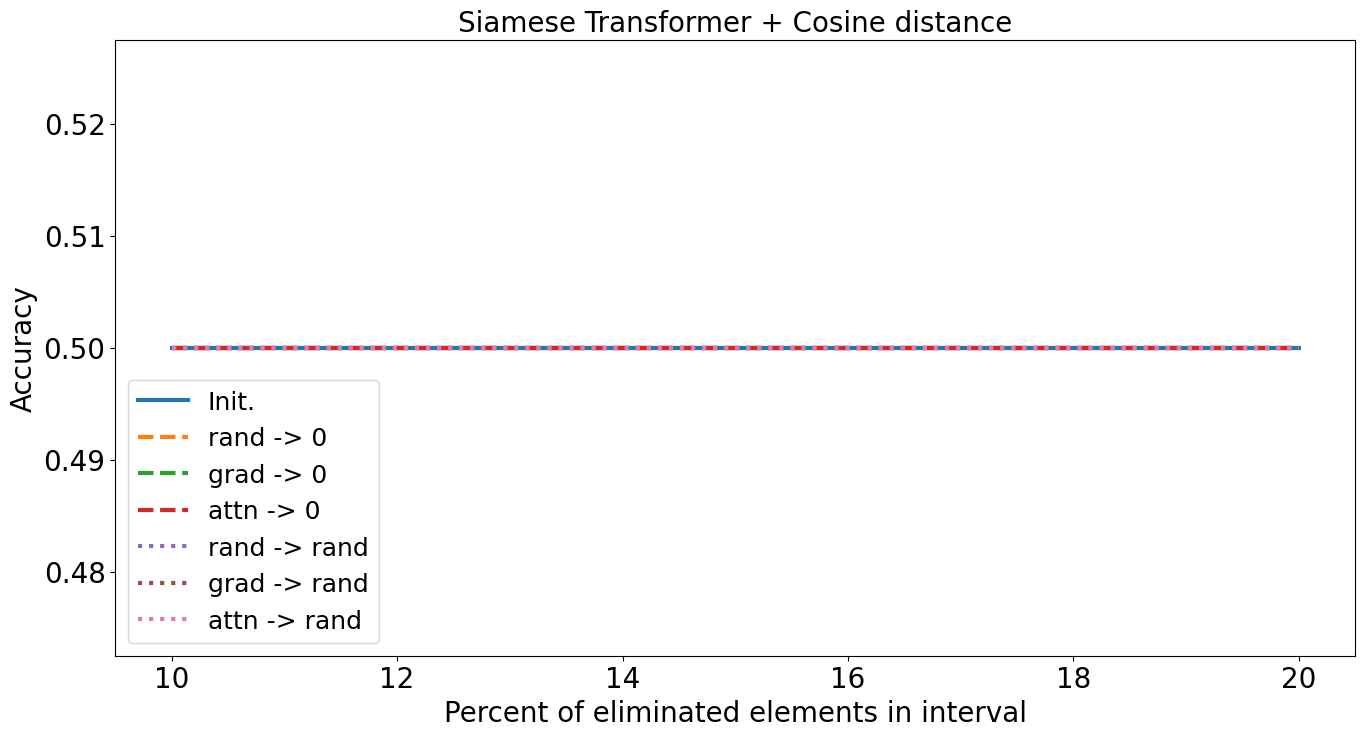

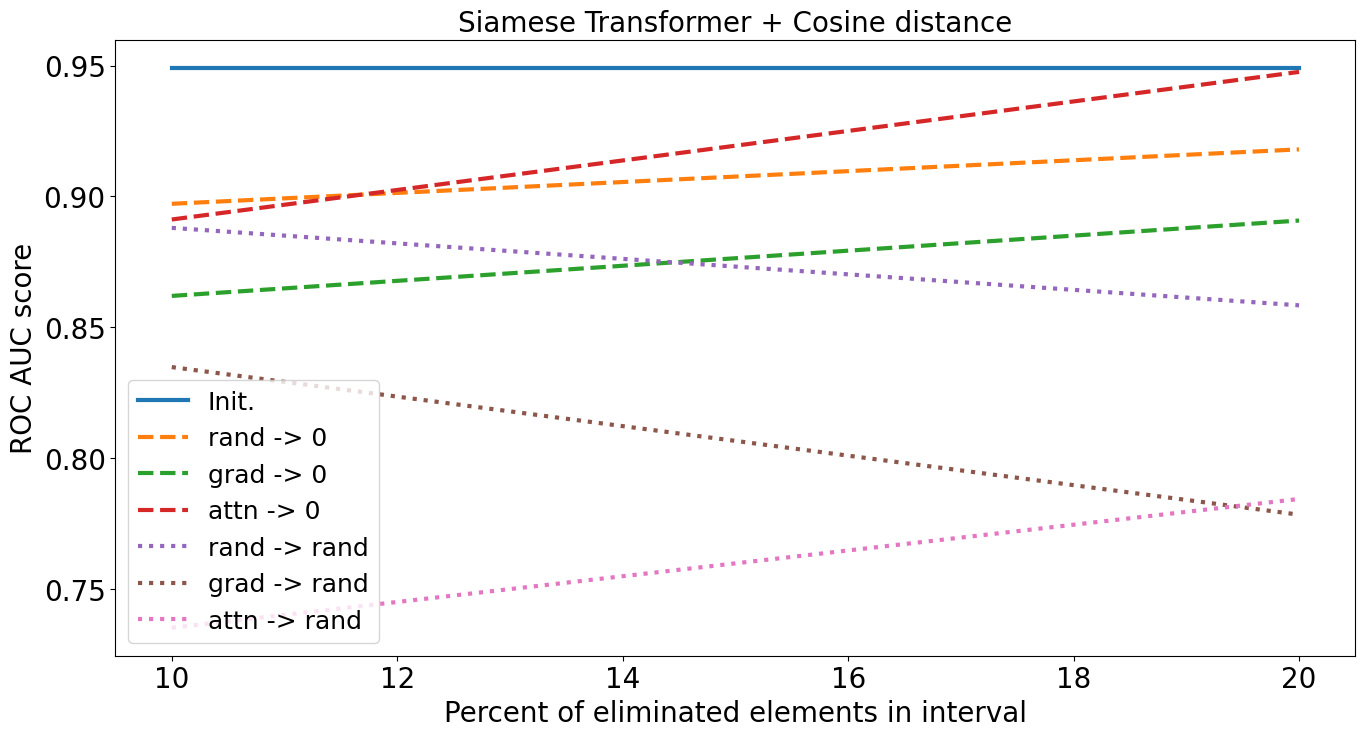

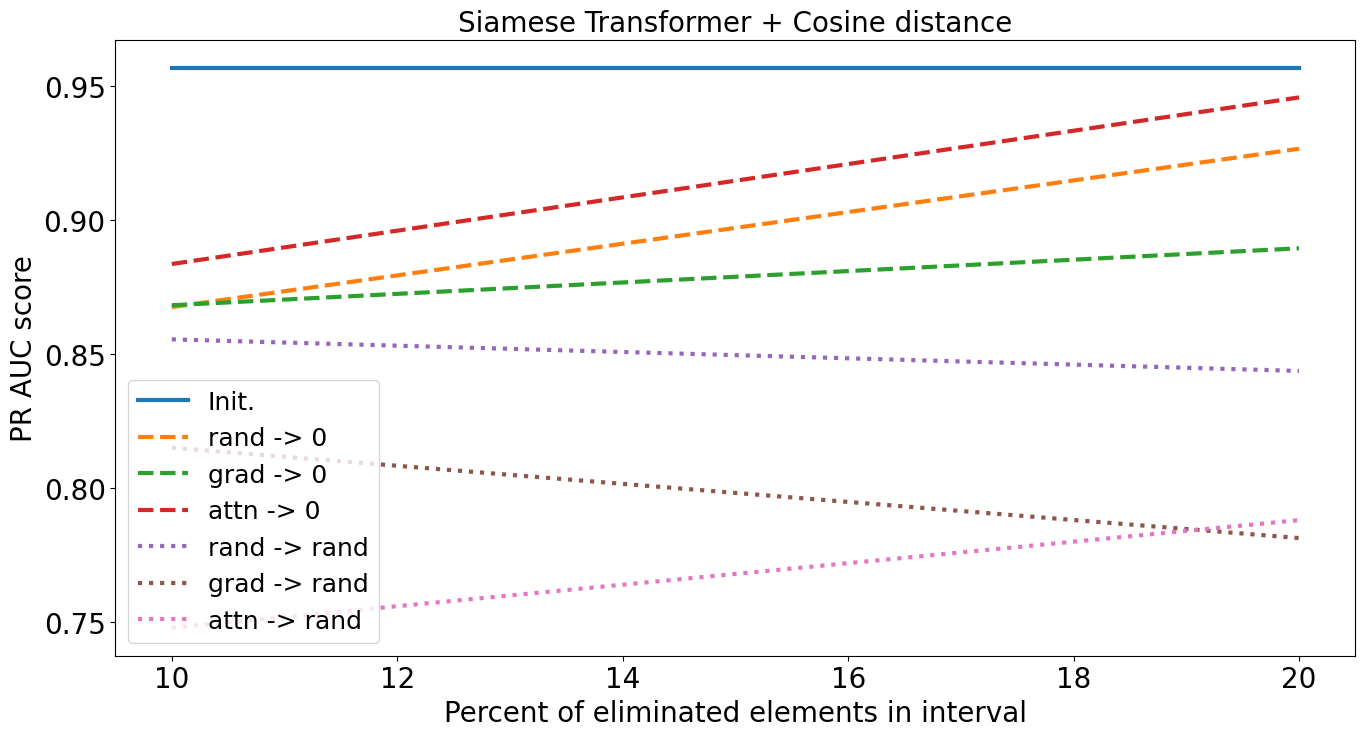

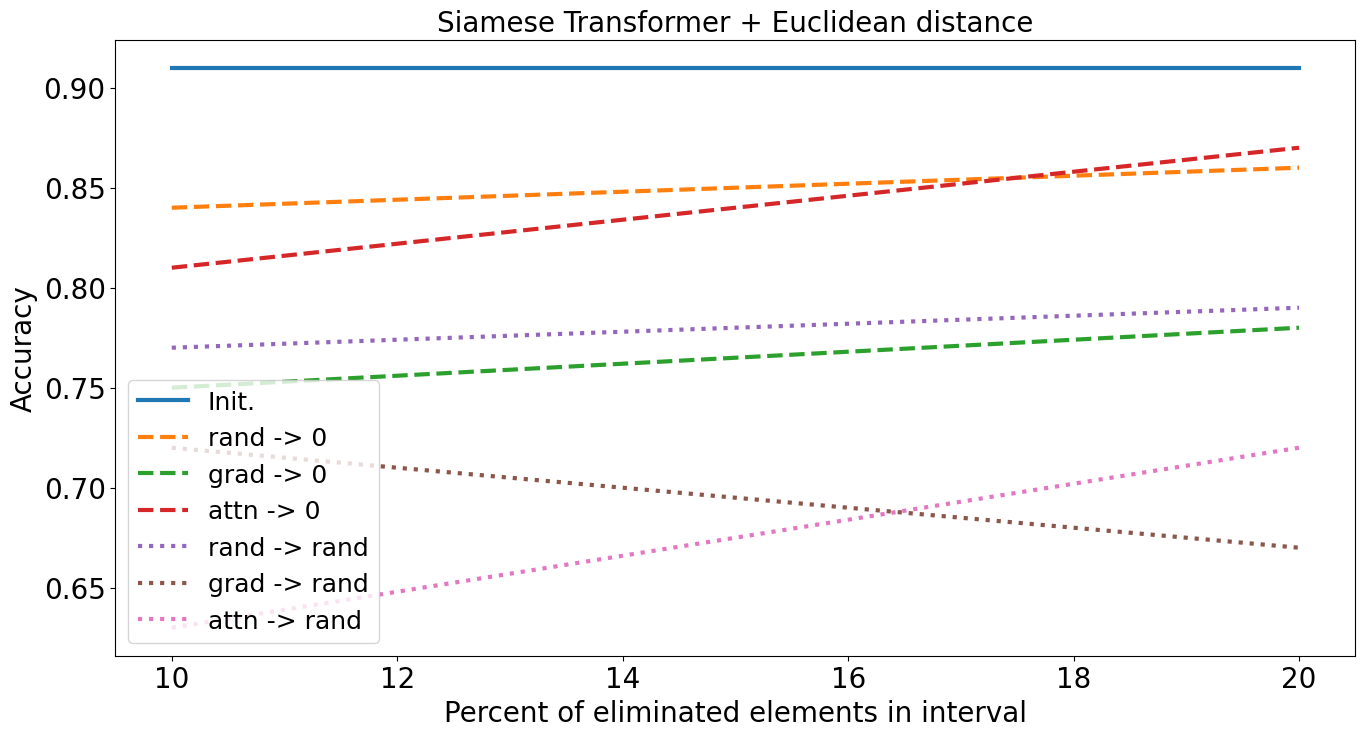

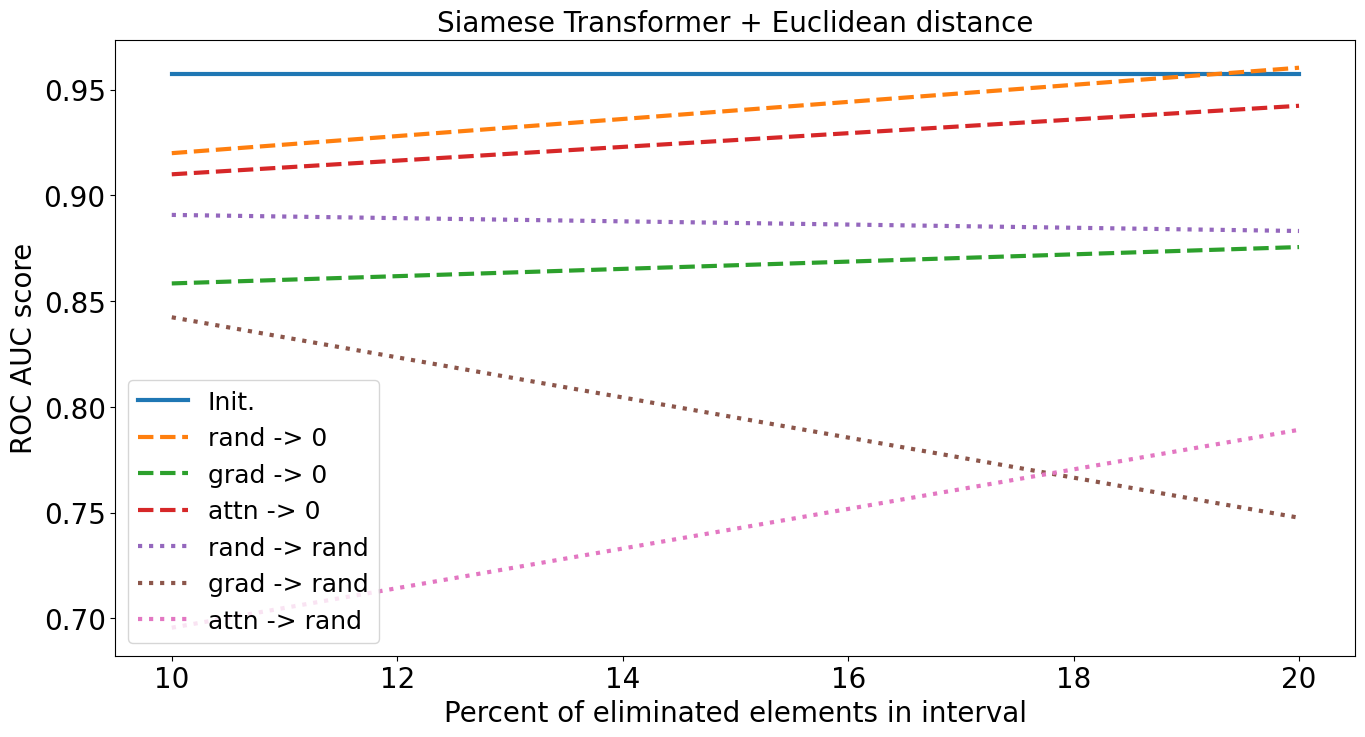

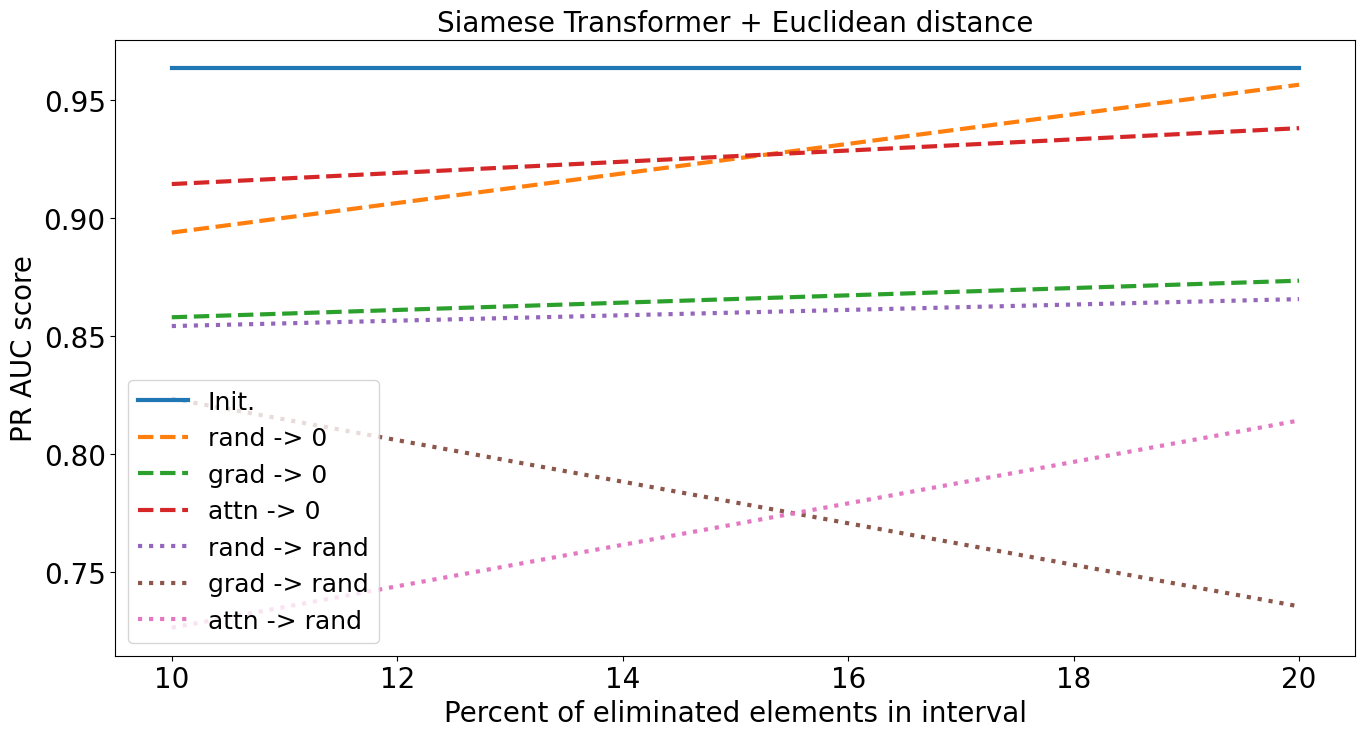

In [24]:
markers = ['o', 'x', '^', 'D', 'v', 's']
elim_type_dict = {
    "init": "Init.",
    "rand_rand": "rand -> rand",
    "rand_0": "rand -> 0",
    "grad_rand": "grad -> rand",
    "grad_0": "grad -> 0",
    "attn_rand": "attn -> rand",
    "attn_0": "attn -> 0",
}
model_type_dict = {
    "siamese": "Siamese",
    "triplet": "Triplet",
}
dist_type_dict = {
    "None": "3 FC",
    "euclidean": "Euclidean distance",
    "cosine": "Cosine distance",
}

for (loss_type, dist_type), data in tr_siam_df.groupby(by=["loss_type", "distance_type"]):
    for metric_name, metric_label in zip(
        ["acc", "roc_auc", "pr_auc"],
        ["Accuracy", "ROC AUC score", "PR AUC score"],
    ):
        plt.figure(figsize=(16, 8))

        c = 0
        for i, (reg_type, df1) in tqdm(enumerate(data.groupby(by='reg_type'))):
            for j, elim_type in enumerate(["init", "rand_0", "grad_0", "attn_0", "rand_rand", "grad_rand", "attn_rand"]):
                df2 = df1[df1['elimination_type'] == elim_type]
                means, stds = [], []
                for p, df3 in df2.groupby(by='p'):
                    means.append(np.nanmean(df3[metric_name].values))
                    stds.append(np.nanstd(df3[metric_name].values))
                
                means = np.array(means)
                stds = np.array(stds)
                
                if elim_type == "init":
                    ls = "solid"
                elif "_0" in elim_type:
                    ls = "dashed"
                elif "_rand" in elim_type:
                    ls = "dotted"
                plt.plot(
                    P,
                    means,
                    label=elim_type_dict[elim_type],
                    c="C{}".format(c),
                    ls=ls,
                    lw=3,
                )
                c += 1
            
        plt.legend(loc='lower left');
        plt.xlabel('Percent of eliminated elements in interval');
        plt.ylabel(metric_label);
        plt.title("{} Transformer + {}".format(model_type_dict[loss_type], dist_type_dict[dist_type]))

        plt.savefig(os.path.join(path_to_save, 'attn_analysis_{}_{}_{}.pdf'.format(metric_name, loss_type, dist_type)), dpi=500, bbox_inches='tight')
        plt.savefig(os.path.join(path_to_save, 'attn_analysis_{}_{}_{}.png'.format(metric_name, loss_type, dist_type)), dpi=500, bbox_inches='tight')

In [25]:
tr_tripl_df = res_df[(res_df["reg_type"] == "transformer") & (res_df["loss_type"] == "triplet")]
tr_tripl_df

,model_type,loss_type,reg_type,p,elimination_type,acc,roc_auc,pr_auc,distance_type
90,None-triplet,triplet,transformer,10,init,0.69,0.9672,0.972971,euclidean
91,None-triplet,triplet,transformer,10,rand_0,0.53,0.9420,0.946089,euclidean
92,None-triplet,triplet,transformer,10,rand_rand,0.50,0.9284,0.930603,euclidean
93,None-triplet,triplet,transformer,10,init,0.62,0.9512,0.956384,cosine
94,None-triplet,triplet,transformer,10,rand_0,0.50,0.9180,0.924901,cosine
95,None-triplet,triplet,transformer,10,rand_rand,0.50,0.9096,0.904163,cosine
96,None-triplet,triplet,transformer,20,init,0.69,0.9672,0.972971,euclidean
97,None-triplet,triplet,transformer,20,rand_0,0.50,0.9420,0.948688,euclidean
98,None-triplet,triplet,transformer,20,rand_rand,0.50,0.8900,0.874996,euclidean
99,None-triplet,triplet,transformer,20,init,0.62,0.9512,0.956384,cosine


1it [00:00, 19.48it/s]


1it [00:00, 26.70it/s]
1it [00:00, 26.53it/s]
1it [00:00, 27.54it/s]
1it [00:00, 26.82it/s]
1it [00:00, 27.26it/s]


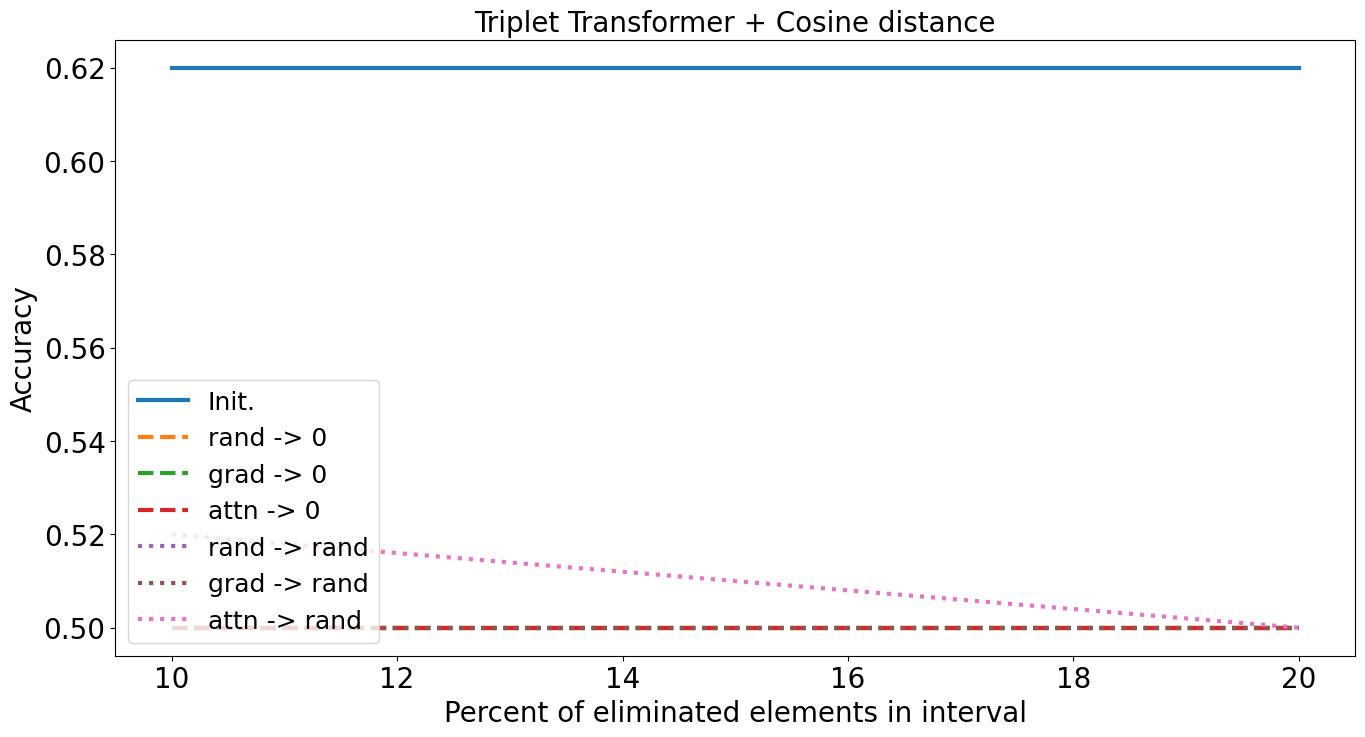

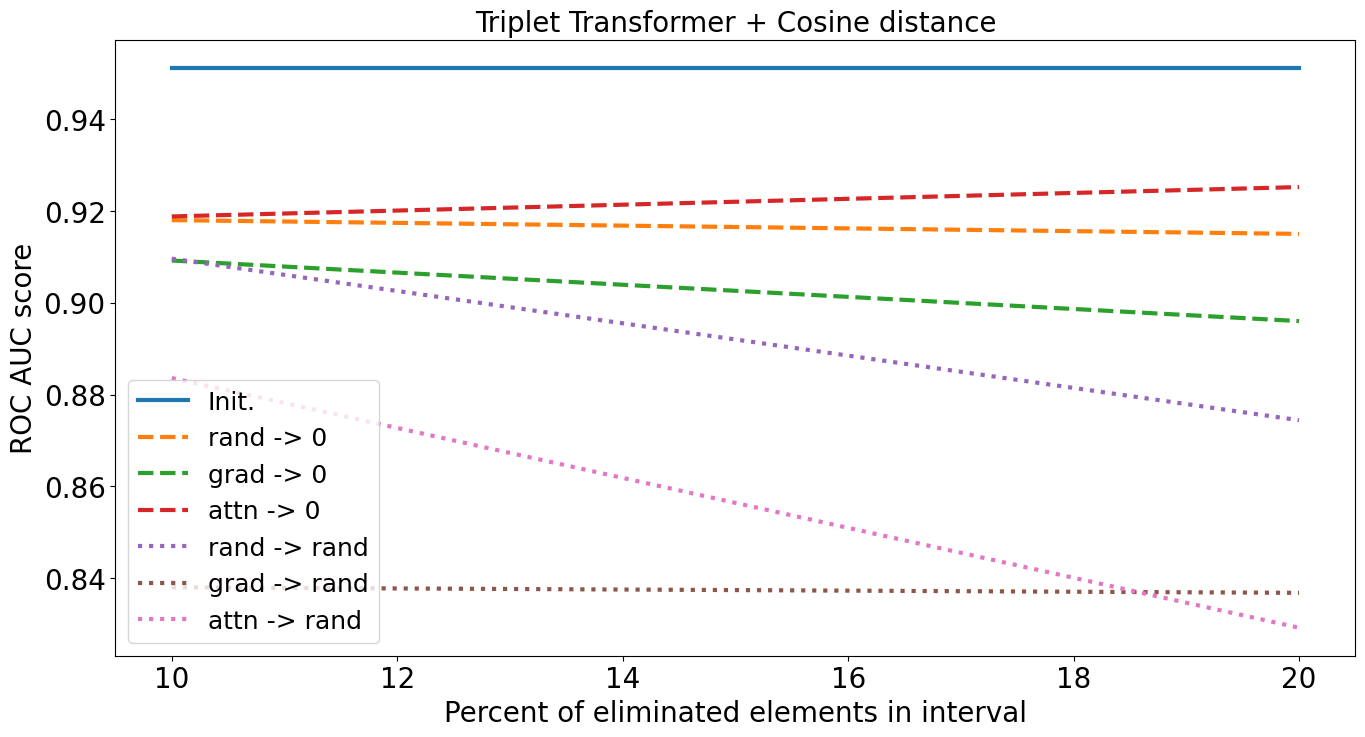

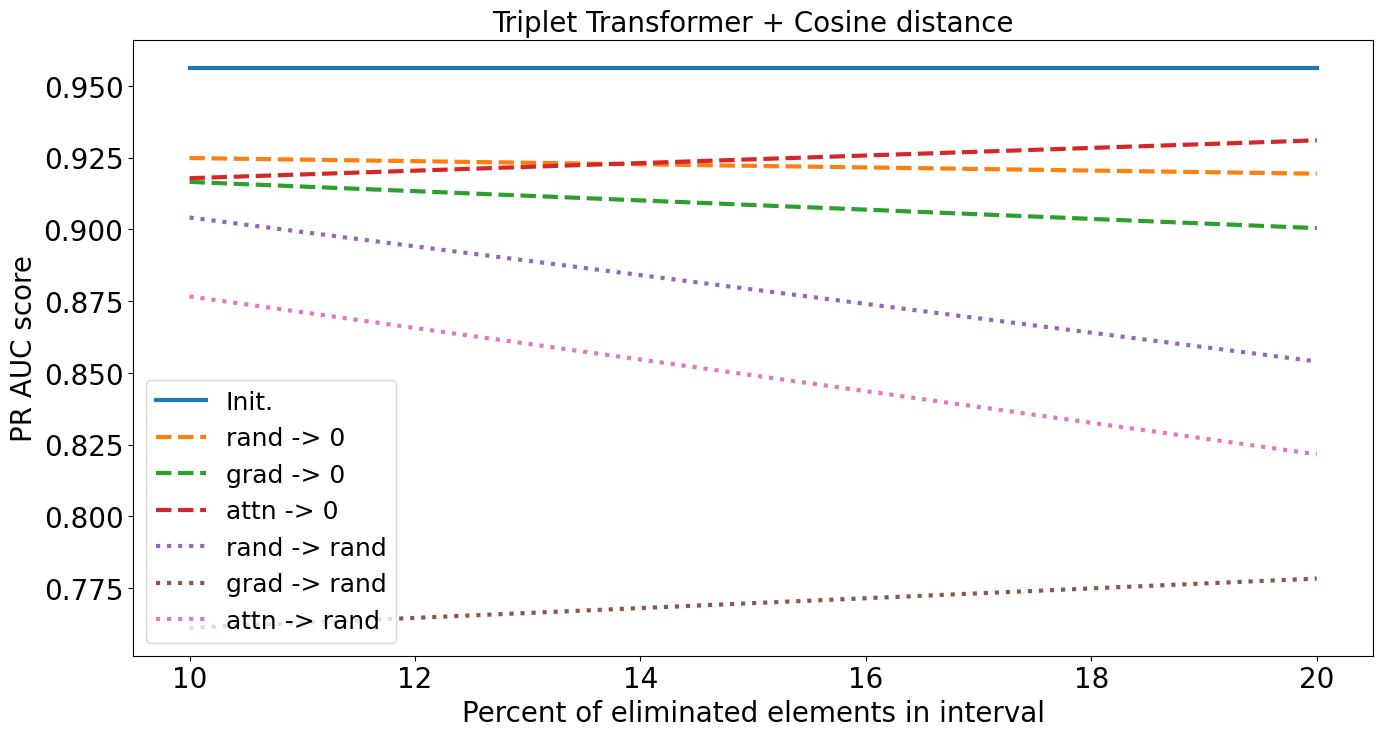

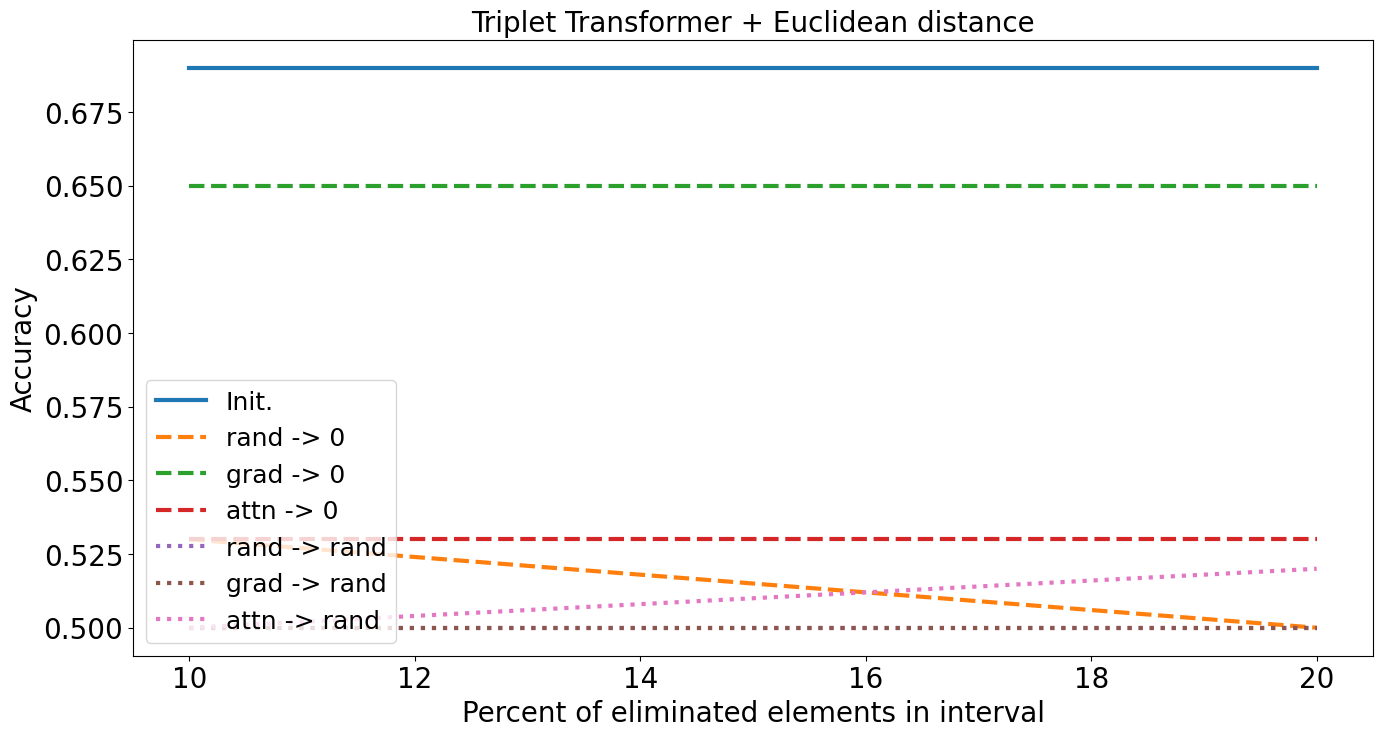

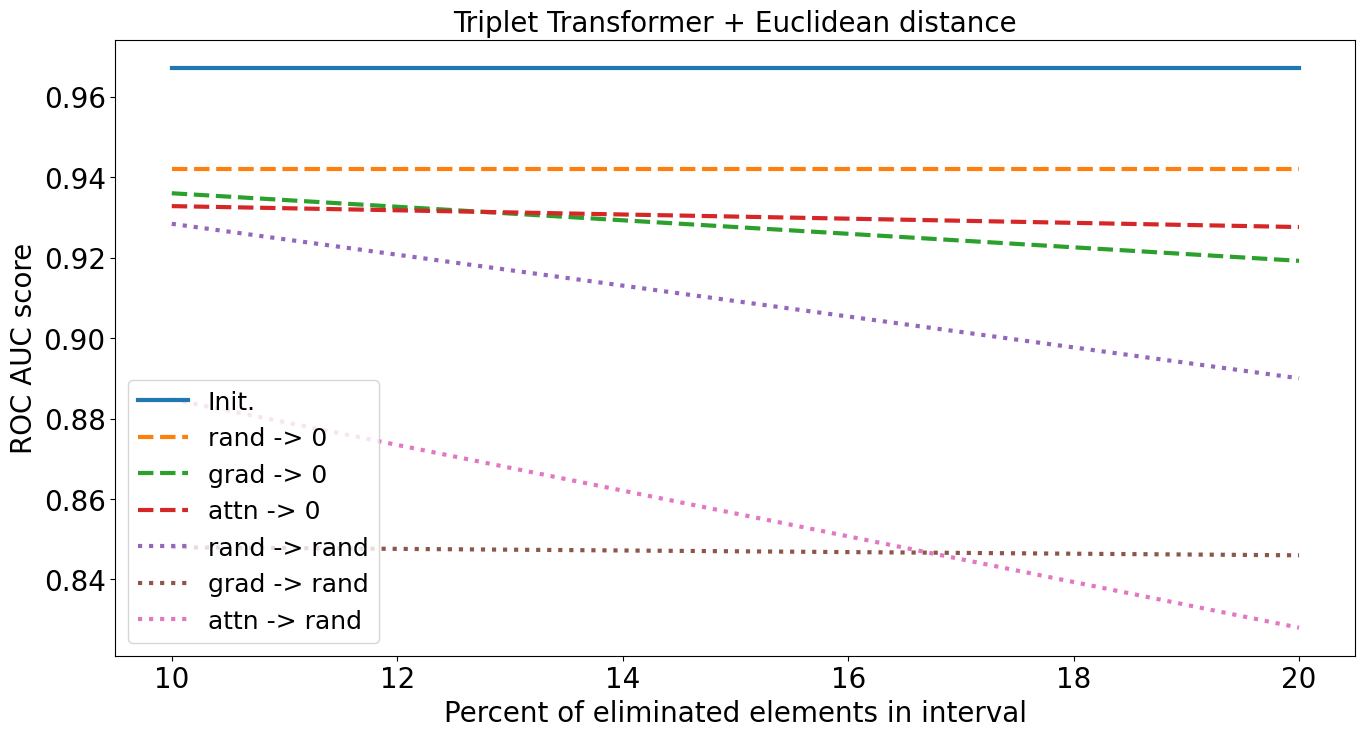

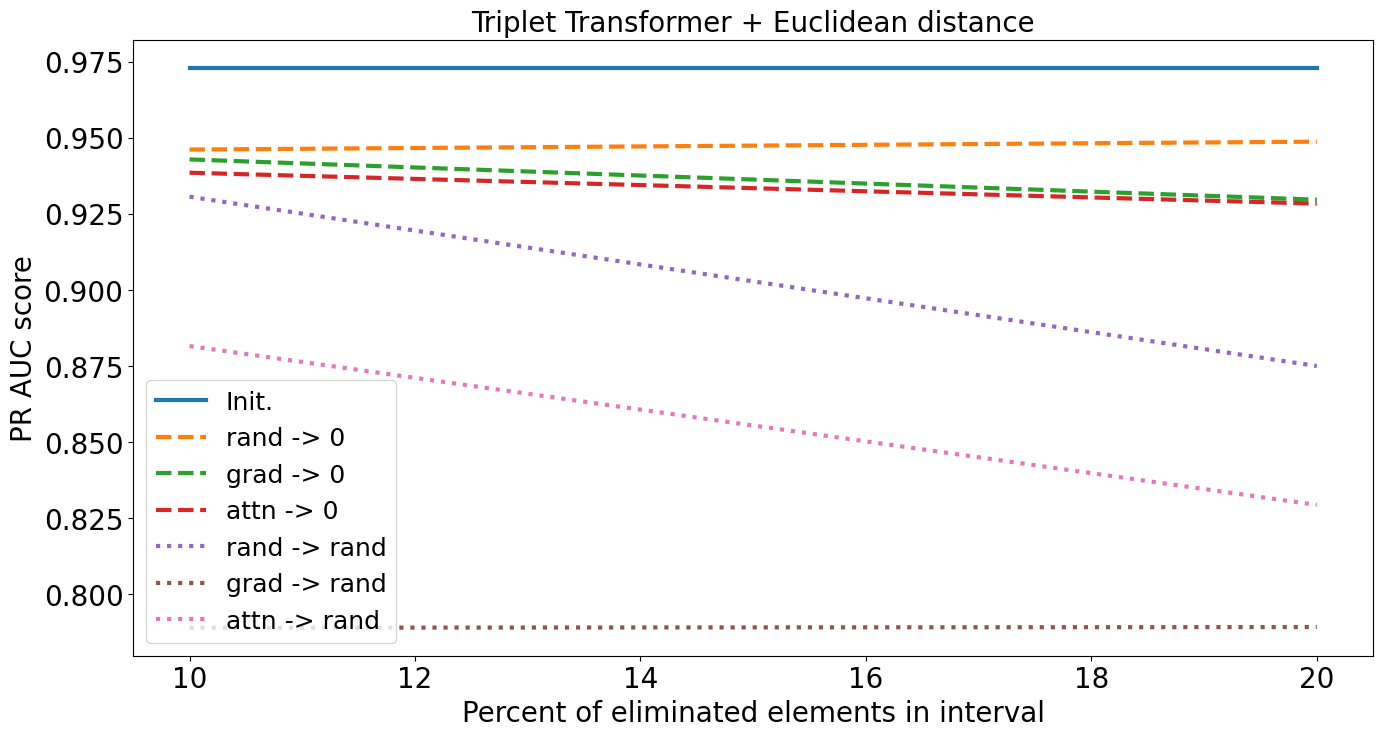

In [26]:
markers = ['o', 'x', '^', 'D', 'v', 's']
elim_type_dict = {
    "init": "Init.",
    "rand_rand": "rand -> rand",
    "rand_0": "rand -> 0",
    "grad_rand": "grad -> rand",
    "grad_0": "grad -> 0",
    "attn_rand": "attn -> rand",
    "attn_0": "attn -> 0",
}
model_type_dict = {
    "siamese": "Siamese",
    "triplet": "Triplet",
}
dist_type_dict = {
    "None": "3 FC",
    "euclidean": "Euclidean distance",
    "cosine": "Cosine distance",
}

for (loss_type, dist_type), data in tr_tripl_df.groupby(by=["loss_type", "distance_type"]):
    for metric_name, metric_label in zip(
        ["acc", "roc_auc", "pr_auc"],
        ["Accuracy", "ROC AUC score", "PR AUC score"],
    ):
        plt.figure(figsize=(16, 8))

        c = 0
        for i, (reg_type, df1) in tqdm(enumerate(data.groupby(by='reg_type'))):
            for j, elim_type in enumerate(["init", "rand_0", "grad_0", "attn_0", "rand_rand", "grad_rand", "attn_rand"]):
                df2 = df1[df1['elimination_type'] == elim_type]
                means, stds = [], []
                for p, df3 in df2.groupby(by='p'):
                    means.append(np.nanmean(df3[metric_name].values))
                    stds.append(np.nanstd(df3[metric_name].values))
                
                means = np.array(means)
                stds = np.array(stds)

                if elim_type == "init":
                    ls = "solid"
                elif "_0" in elim_type:
                    ls = "dashed"
                elif "_rand" in elim_type:
                    ls = "dotted"
                plt.plot(
                    P,
                    means,
                    label=elim_type_dict[elim_type],
                    c="C{}".format(c),
                    ls=ls,
                    lw=3,
                )
                c += 1
            
        plt.legend(loc='lower left');
        plt.xlabel('Percent of eliminated elements in interval');
        plt.ylabel(metric_label);
        plt.title("{} Transformer + {}".format(model_type_dict[loss_type], dist_type_dict[dist_type]))

        plt.savefig(os.path.join(path_to_save, 'attn_analysis_{}_{}_{}.pdf'.format(metric_name, loss_type, dist_type)), dpi=500, bbox_inches='tight')
        plt.savefig(os.path.join(path_to_save, 'attn_analysis_{}_{}_{}.png'.format(metric_name, loss_type, dist_type)), dpi=500, bbox_inches='tight')